In [1]:
import glob
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    AutoModelForSequenceClassification,
    AutoTokenizer
)






In [2]:

# =========================================
# 3) Konfiguration der Basismodelle
# =========================================

# Beispielsweise 2 Modelle: BERT & RoBERTa (du kannst auch andere Pfade/Modelle angeben)
model_paths = {
    "scibert_Pretrained": r"model_training\nlp\attitude_classifier\scibert_Pretrained",
    "scibert_Original": "allenai/scibert_scivocab_uncased", 
    "bert_base": "google-bert/bert-base-uncased",
    "bert_pretrained" : r"model_training\nlp\attitude_classifier\bert_pretrained",
}


file_path_pattern = r'model_training\nlp\attitude_classifier\*.csv'


In [3]:

# =========================================
# 1) Daten laden und aufbereiten
# =========================================

csv_files = glob.glob(file_path_pattern)

if len(csv_files) == 0:
    raise FileNotFoundError("Keine CSV-Dateien im angegebenen Verzeichnis gefunden.")

# CSVs laden und zu einem DataFrame kombinieren
combined_df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

df = combined_df[['text', 'aspect']].rename(columns={'aspect': 'labels', 'text': 'data'})
df.drop_duplicates(subset=['data', 'labels'], keep='first', inplace=True)

# Entferne Zeilen mit weniger als 3 Wörtern
df = df[df['data'].apply(lambda x: len(str(x).split()) >= 3)]

# Alle möglichen Labels (inkl. "None", falls vorhanden)
all_labels_list = [
    "none",
    "asp_substance",
    "asp_originality",
    "asp_clarity",
    "asp_soundness-correctness",
    "asp_motivation-impact",
    "asp_meaningful-comparison",
    "asp_replicability",
    "arg_other"
]

# Dictionary: int_to_label und label_to_int
int_to_label = {i: label for i, label in enumerate(all_labels_list)}
label_to_int = {label: i for i, label in int_to_label.items()}

# Wandle die Labels in Integer
df["encoded_cat"] = df["labels"].apply(lambda x: label_to_int[x])

# Wir wollen einen 70-20-10 Split
# Zuerst 70% Trainingsdaten, 30% Rest
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["encoded_cat"])

# Von den verbleibenden 30% -> 20/10 split => 2/3:1/3
val_df, test_df = train_test_split(temp_df, test_size=0.3333, random_state=42, stratify=temp_df["encoded_cat"])

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")



Train: 6390, Val: 1826, Test: 913


C:\Users\Johannes\AppData\Local\Temp\ipykernel_9512\1943229676.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


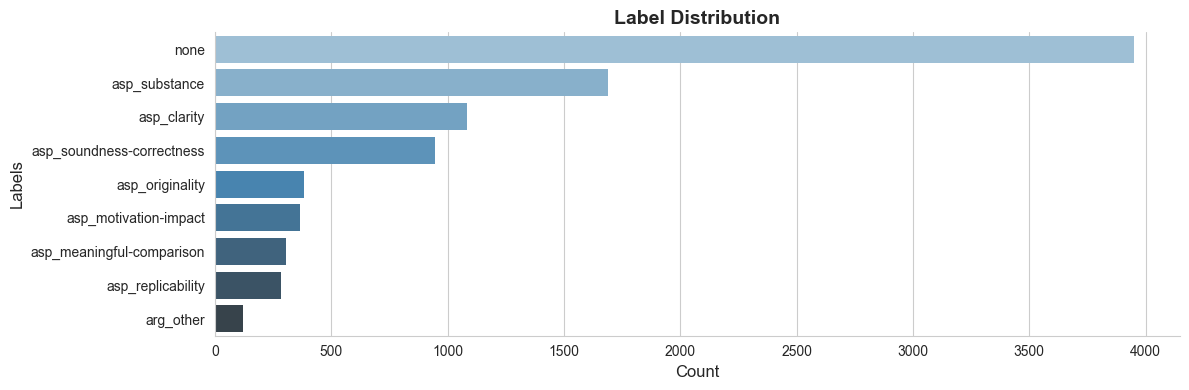

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Set a clean aesthetic style
sns.set_style("whitegrid")

# 2) Count the labels and sort descending
label_counts = df["labels"].value_counts().sort_values(ascending=False)

# 3) Create a wide, shallow figure
plt.figure(figsize=(12, 4))

# 4) Plot a horizontal bar chart
#    (x-axis = counts, y-axis = labels)
sns.barplot(
    x=label_counts.values,
    y=label_counts.index,
    palette="Blues_d",
    edgecolor='none',   # No black border
    linewidth=0
)

# 5) Label axes and add a title
plt.xlabel("Count", fontsize=12)
plt.ylabel("Labels", fontsize=12)
plt.title("Label Distribution", fontsize=14, fontweight="bold")

# 6) Remove unnecessary spines and tighten layout
sns.despine()
plt.tight_layout()

# 7) Optional: Save as a high-resolution PNG for Word
plt.savefig("label_distribution_horizontal.png", dpi=300)

# 8) Display the figure
plt.show()


In [6]:
# =========================================
# 2) Hilfsfunktionen
# =========================================

def oversample_dataframe(input_df, skip_label="None"):
    """
    Einfache Oversampling-Funktion, die jede Klasse (außer skip_label) um den Faktor 2 erhöht.
    Passe dies nach Bedarf an (z.B. max_count, SMOTE etc.).
    """
    aspects = [lbl for lbl in all_labels_list if lbl != skip_label]  # Label "None" oversample wir hier nicht, Beispiel
    output_df = input_df.copy()

    for aspect in aspects:
        subset = output_df[output_df["labels"] == aspect]
        count = len(subset)
        if count > 0:
            resampled = subset.sample(n=count, replace=True, random_state=42)
            output_df = pd.concat([output_df, resampled], ignore_index=True)
    return output_df

def encode_data(tokenizer, df):
    """ Tokenisiert und gibt Encodings + Labels (Torch Tensor) zurück. """
    texts = df["data"].tolist()
    labels = df["encoded_cat"].tolist()

    encodings = tokenizer(texts, truncation=True, padding=True)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return encodings, labels_tensor

class CustomDataset(Dataset):
    """Einfaches Dataset für den Trainer."""
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

def compute_metrics(pred):
    """Einfacher Accuracy-Score als Beispiel."""
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = (preds == labels).mean()
    return {"accuracy": accuracy}

def create_trainer(model, tokenizer, train_df, val_df, num_epochs=4, output_dir="./results"):
    """
    Erstellt einen Trainer mit übergebenem Modell, Tokenizer, Trainings- & Validierungs-Daten.
    num_epochs: Anzahl der Epochen
    """
    train_encodings, train_labels = encode_data(tokenizer, train_df)
    val_encodings, val_labels = encode_data(tokenizer, val_df)

    train_dataset = CustomDataset(train_encodings, train_labels)
    val_dataset   = CustomDataset(val_encodings,   val_labels)

    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=5e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        num_train_epochs=num_epochs,
        weight_decay=0.01,
        logging_dir='./logs',
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        save_total_limit=2
    )

    early_stopping = EarlyStoppingCallback(
        early_stopping_patience=3,
        early_stopping_threshold=0.0
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping]  # <- Wichtig: Liste mit Callback(s)
    )

    return trainer




In [7]:
def train_approach_1(model_class, tokenizer_class, model_path, model_name):
    """
    Ansatz (1): 2 Epochen, kein Oversampling
    """
    out_dir = f"./results_approach1_{model_name}"  # Dynamischer Ordner

    model = model_class.from_pretrained(
        model_path,
        num_labels=len(all_labels_list),
        problem_type="single_label_classification",
        ignore_mismatched_sizes=True
    )
    tokenizer = tokenizer_class.from_pretrained(model_path)

    # Trainer erstellen mit dynamischem output_dir
    trainer = create_trainer(model, tokenizer, train_df, val_df, num_epochs=4, output_dir=out_dir)
    trainer.train()

    # Evaluate final Test
    test_encodings, test_labels = encode_data(tokenizer, test_df)
    test_dataset = CustomDataset(test_encodings, test_labels)
    final_eval_results = trainer.evaluate(test_dataset)
    print("Ansatz (1) - Final Test Results:", final_eval_results)

    # Optional: Modell & Tokenizer explizit speichern
    # (Der Trainer speichert Checkpoints sowieso nach jeder Epoche, 
    #  aber falls du z. B. noch mal "das finale" abspeichern willst):
    trainer.save_model(out_dir)
    tokenizer.save_pretrained(out_dir)

    return model, tokenizer, trainer


def train_approach_2(model_class, tokenizer_class, model_path, model_name):
    """
    Ansatz (2): 2 Epochen, mit Oversampling
    """
    oversampled_train_df = oversample_dataframe(train_df)
    out_dir = f"./results_approach2_{model_name}"

    model = model_class.from_pretrained(
        model_path,
        num_labels=len(all_labels_list),
        problem_type="single_label_classification",
        ignore_mismatched_sizes=True
    )
    tokenizer = tokenizer_class.from_pretrained(model_path)

    trainer = create_trainer(model, tokenizer, oversampled_train_df, val_df,
                             num_epochs=4, output_dir=out_dir)
    trainer.train()

    # Evaluate final Test
    test_encodings, test_labels = encode_data(tokenizer, test_df)
    test_dataset = CustomDataset(test_encodings, test_labels)
    final_eval_results = trainer.evaluate(test_dataset)
    print("Ansatz (2) - Final Test Results:", final_eval_results)

    # Speichern
    trainer.save_model(out_dir)
    tokenizer.save_pretrained(out_dir)

    return model, tokenizer, trainer


def train_approach_3(model_class, tokenizer_class, model_path, model_name):
    """
    Ansatz (3): 1 Epoche oversampling + 1 Epoche kein Oversampling
    (Zweite Epoche nutzt das "weitertrainierte" Modell aus Epoche 1)
    """
    out_dir_stepA = f"./results_approach3_stepA_{model_name}"
    out_dir_stepB = f"./results_approach3_stepB_{model_name}"

    # Schritt A: Oversampling
    oversampled_train_df = oversample_dataframe(train_df)
    model_stepA = model_class.from_pretrained(
        model_path,
        num_labels=len(all_labels_list),
        problem_type="single_label_classification",
        ignore_mismatched_sizes=True
    )
    tokenizer_stepA = tokenizer_class.from_pretrained(model_path)

    trainer_stepA = create_trainer(model_stepA, tokenizer_stepA,
                                   oversampled_train_df, val_df,
                                   num_epochs=2, output_dir=out_dir_stepA)
    trainer_stepA.train()

    # Schritt B: 1 Epoche Original train_df
    trainer_stepB = create_trainer(model_stepA, tokenizer_stepA,
                                   train_df, val_df,
                                   num_epochs=2, output_dir=out_dir_stepB)
    trainer_stepB.train()

    # Evaluate final
    test_encodings, test_labels = encode_data(tokenizer_stepA, test_df)
    test_dataset = CustomDataset(test_encodings, test_labels)
    final_eval_results = trainer_stepB.evaluate(test_dataset)
    print("Ansatz (3) - Final Test Results:", final_eval_results)

    # Speichern (Endzustand nach Epoche B)
    trainer_stepB.save_model(out_dir_stepB)
    tokenizer_stepA.save_pretrained(out_dir_stepB)

    return model_stepA, tokenizer_stepA, trainer_stepB


In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def plot_confusion_matrix(model, tokenizer, test_df, title="Confusion Matrix"):
    preds = []
    test_texts = test_df["data"].tolist()
    test_labels_list = test_df["encoded_cat"].tolist()

    for txt, _ in zip(test_texts, test_labels_list):
        inputs = tokenizer(txt, truncation=True, padding=True, return_tensors="pt")
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        pred_label = torch.argmax(logits, dim=1).item()
        preds.append(pred_label)

    cm = confusion_matrix(test_labels_list, preds)
    plt.figure(figsize=(10, 8))
    class_names = ["none", "substance", "orginality", "clarity", "soundness-correctness", "motivation-impact", "meaningful-comparison", "replicability", "other"]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    print(classification_report(test_labels_list, preds, target_names=class_names))


In [9]:
# =========================================
# 5) Hauptschleife: Trainiere alle Modelle 
#    mit allen Ansätzen
# =========================================
# Beispiel-Imports (bitte anpassen oder ersetzen)

for model_name, path in model_paths.items():
    print("="*60)
    print(f"Starte Trainingsrunden für Modell: {model_name}")
    print("="*60)

    # Wähle dynamisch die richtige Klasse
    # (Beispiel, falls du BERT und RoBERTa separat definieren willst)
    if model_name == "BERT":
        model_class = BertForSequenceClassification
        tokenizer_class = BertTokenizer
    elif model_name == "RoBERTa":
        model_class = RobertaForSequenceClassification
        tokenizer_class = RobertaTokenizer
    else:
        # Für SciBERT oder sonstiges kann man auch Auto-Klassen verwenden
        model_class = AutoModelForSequenceClassification
        tokenizer_class = AutoTokenizer

    # Ansatz 1
    print(f"\n>>> {model_name} - Ansatz (1) - KEIN Oversampling")
    model1, tokenizer1, trainer1 = train_approach_1(model_class, tokenizer_class, path, model_name)
    plot_confusion_matrix(model1, tokenizer1, test_df, title=f"{model_name} Ansatz 1")

    # Ansatz 2
    print(f"\n>>> {model_name} - Ansatz (2) - VOLLES Oversampling")
    model2, tokenizer2, trainer2 = train_approach_2(model_class, tokenizer_class, path, model_name)
    plot_confusion_matrix(model2, tokenizer2, test_df, title=f"{model_name} Ansatz 2")

    # Ansatz 3
    print(f"\n>>> {model_name} - Ansatz (3) - 1 Epoche Oversampling + 1 Epoche kein Oversampling")
    model3, tokenizer3, trainer3 = train_approach_3(model_class, tokenizer_class, path, model_name)
    plot_confusion_matrix(model3, tokenizer3, test_df, title=f"{model_name} Ansatz 3")

print("Fertig!")

      

Starte Trainingsrunden für Modell: scibert_Pretrained

>>> scibert_Pretrained - Ansatz (1) - KEIN Oversampling


OSError: Incorrect path_or_model_id: 'C:\Users\carme\OneDrive - Appelt Steuerberatung\Carmen Appelt\Master\Semester 3\DASP\models\scibert_all\scibert_scivocab_uncased'. Please provide either the path to a local folder or the repo_id of a model on the Hub.